# Когортный анализ

Изучить сервис, собрать данные о первой покупке, LTV и CAC, оценить рекламные траты, оптимизировать маркетинговый бюджет.

Данные с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиша,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

## Шаг 1. Чтение и обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')


visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()


visits = visits.rename(
    {'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts'}, 
    axis='columns'
)
orders = orders.rename(
    {'buy ts': 'buy_ts'},
    axis='columns'
)
visits = visits.astype(
    {'end_ts': 'datetime64', 'start_ts': 'datetime64'}
)
orders = orders.astype(
    {'buy_ts': 'datetime64'}
)
costs = costs.astype(
    {'dt': 'datetime64'}
)

costs.info()
print(costs)
print(orders)
#orders.duplicated().sum()
visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
      source_id         dt  costs
0             1 2017-06-01  75.20
1             1 2017-06-02  62.25
2             1 2017-06-03  36.53
3             1 2017-06-04  55.00
4             1 2017-06-05  57.08
...         ...        ...    ...
2537         10 2018-05-27   9.92
2538         10 2018-05-28  21.26
2539         10 2018-05-29  11.32
2540         10 2018-05-30  33.15
2541         10 2018-05-31  17.60

[2542 rows x 3 columns]
                   buy_ts  revenue                   uid
0     2017-06-01 00:10:00    17.00  10329302124590727494
1     2017-06-01 00:25:00     0.55  11627257723692907447
2     2017-06-01 00:27:00     0.37  17903680561304213844
3     2017-06-01 00:29:00     0.55  16109239769442553

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


### Вывод
1. Привел названия столбцов к нижнему регистру
2. Убрал пробелы из названий столбцов
3. Привел данные со временем к формату datetime64

## Шаг 2. Рассчет метрик - продуктовые, э-коммерции, маретинговые


### Продуктовые метрики - рассчет DAU (Daily Active Users), WAU, MAU

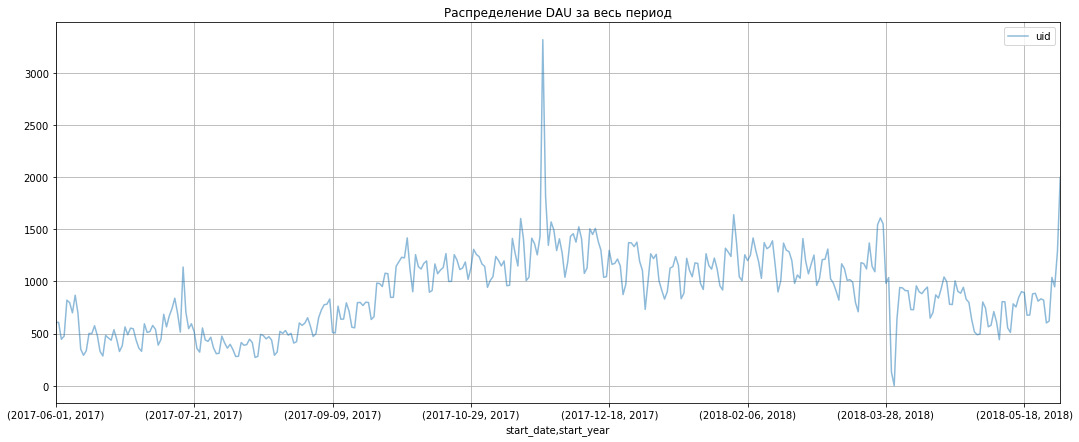

Среднее значение DAU за весь период: 907


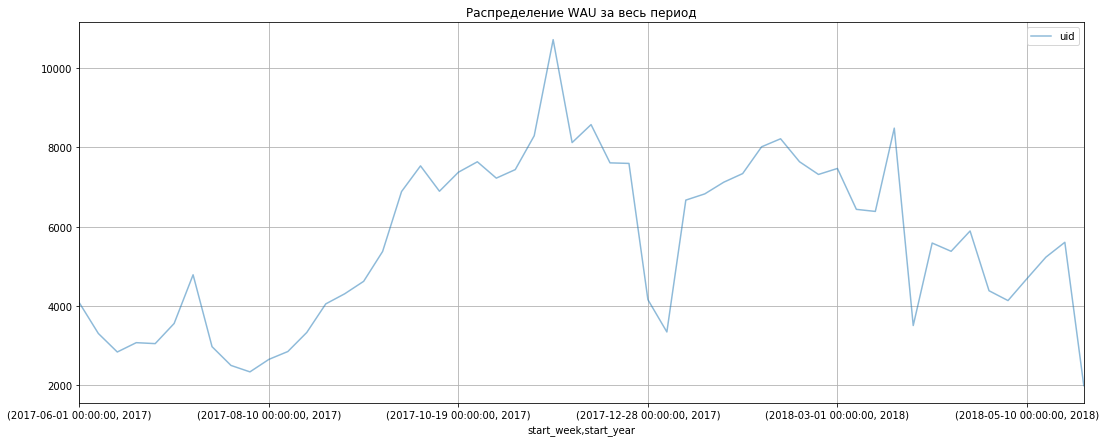

Среднее значение WAU за весь период: 5621


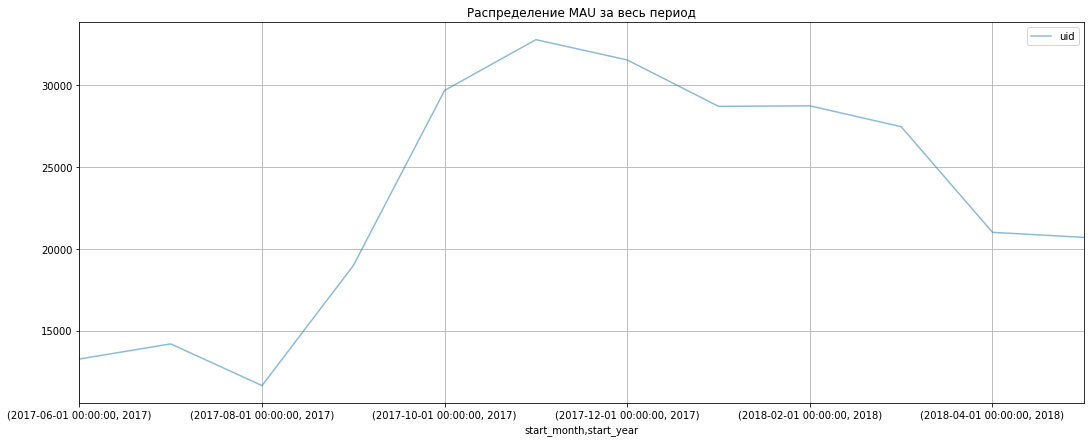

Среднее значение MAU за весь период: 23228


In [2]:
visits['start_date'] = visits['start_ts'].dt.date
visits['start_week'] = visits['start_ts'].astype('datetime64[W]')
visits['start_month'] = visits['start_ts'].astype('datetime64[M]')
visits['start_year'] = visits['start_ts'].dt.year

def dmwau(dmw, name):
    distr = visits.groupby([dmw, 'start_year']).agg({'uid': 'nunique'})
    distr.plot(
        alpha = 0.5, 
        figsize=(18, 7), 
        grid=True)
    plt.legend()
    plt.title('Распределение {} за весь период'.format(name))
    plt.show()
    print('Среднее значение {} за весь период: {}'.format(name, int(distr.mean())))
    
dmwau('start_date', 'DAU')
dmwau('start_week', 'WAU')
dmwau('start_month', 'MAU')

### Вывод:
- в середине периода виден всплеск посещений, возможно, были скидки к новому году
- средние DAU - 907, WAU - 5716, MAU - 23228
- значения без выбросов и просадок, не вызывают подозрений

### Продуктовые метрики

Среднее значение входов на сайт за весь период: 907


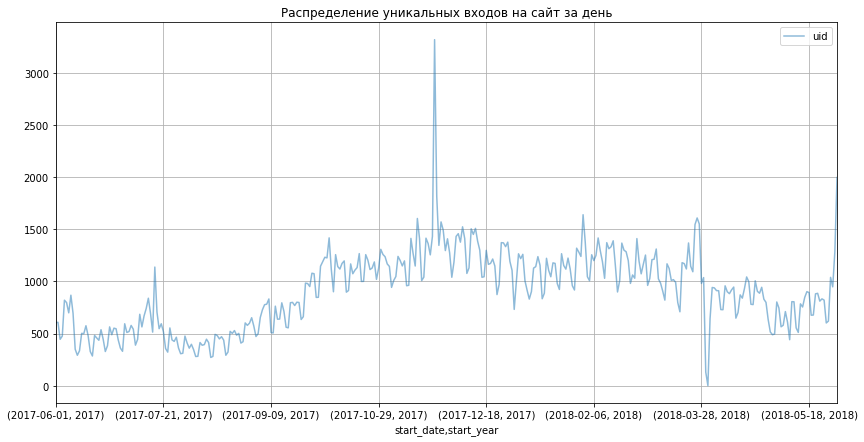

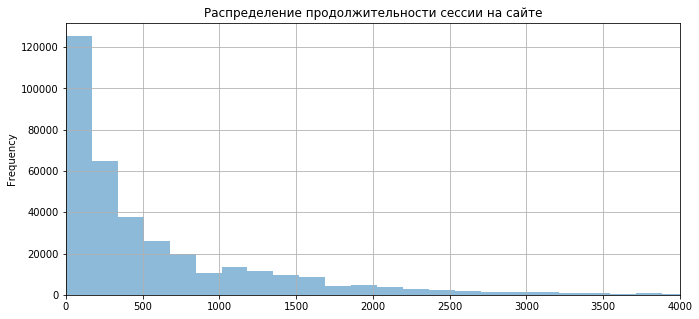

Чаще всего продолжительность сессии (ASL) равна:60 секунд


In [3]:
day_visits = visits.groupby(['start_date', 'start_year']).agg({'uid': 'nunique'})
day_visits.plot(
    alpha = 0.5, 
    figsize=(14, 7), 
    grid=True)
plt.legend()
plt.title('Распределение уникальных входов на сайт за день')
print('Среднее значение входов на сайт за весь период: {}'.format(int(day_visits.mean())))
plt.show()

visits['duration_ts'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['duration_ts'].plot(
    kind='hist',
    bins=500,
    xlim=(0, 4000),
    alpha = 0.5, 
    figsize=(11, 5), 
    grid=True)
plt.title('Распределение продолжительности сессии на сайте')
plt.show()
print('Чаще всего продолжительность сессии (ASL) равна:{} секунд'.format(
    int(visits['duration_ts'].mode()))
     )

### Вывод:
- распределение посещений сайта в день очень походе на DAU, среднее значение посещений 987 против 907 уникальных посещений. Это говорит о том, что 90% посещений сайта уникальные, мало кто посещяет сайт более 1 раза в день.
- Средняя продолжительность сессии - 60 секунд. 

### Продуктовые метрики
- Рассчет Retention Rate

In [4]:
first_activity = visits.groupby('uid')['start_ts'].min()
first_activity.name = 'first_activity_datetime'
visits = visits.join(first_activity, on='uid')
#вынес джойн в отдельную ячеку, чтобы свободно перезапускать ячейку ниже

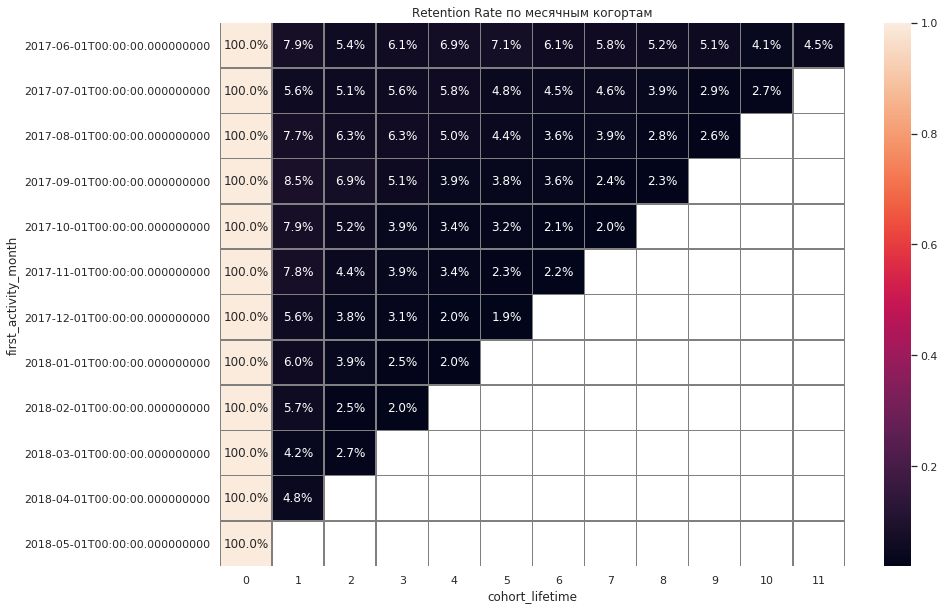

Средний Retention Rate на второй месяц жизни когорт равен 6.5%


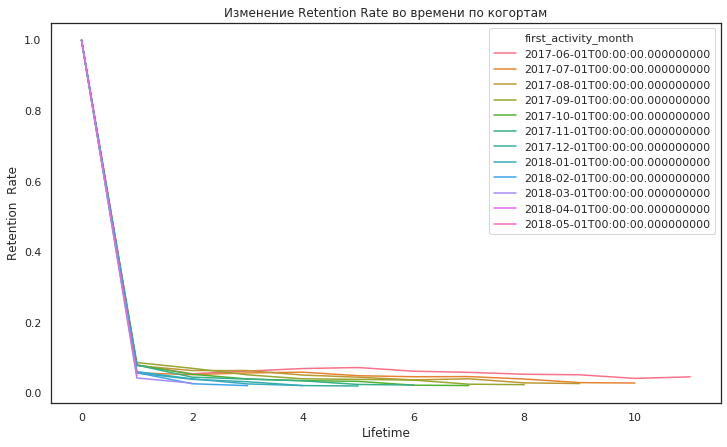

In [5]:
visits['first_activity_month'] = visits['first_activity_datetime'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

cohorts = visits.groupby(
    ['first_activity_month', 'cohort_lifetime']
).agg({'uid': 'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)
sns.set(style='white')
plt.figure(figsize=(14, 10))
plt.title('Retention Rate по месячным когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=0.5, linecolor='gray')
plt.show()

print('Средний Retention Rate на второй месяц жизни когорт равен {:.1%}'.format(
    cohorts.query('cohort_lifetime == 1')['retention'].mean())
     )

plt.figure(figsize=(12, 7))
sns.lineplot(x='cohort_lifetime', y='retention', hue='first_activity_month', data=cohorts)
plt.ylabel('Retention  Rate')
plt.xlabel('Lifetime')
plt.title('Изменение Retention Rate во времени по когортам')
plt.show()

### Вывод:
- Retantion Rate по когортам в среднем, по всем когортам падает, но у первой когорты он держится выше 4% все 11 месяцев
- у более молодых когорт падение происходит быстрее, видимо, спал ажиотаж на покупку билетов на Яндекс.Афише. 
- в среднем, Retantion Rate на второй месяц составляет 6.5%
- когорты от 2017-12-01 пробивают 4% вниз по Retention Rate уже со второго месяца существования когорты.

### Метрики электронной коммерции
- Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Изучать изменение этой метрики во времени необязательно;
- Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период, например за 6 месяцев. Изучать изменение этой метрики во времени необязательно;

In [6]:
first_customers_order = orders.groupby('uid')['buy_ts'].min()
first_customers_order.name = 'first_order_datetime'
visits = visits.join(first_customers_order, on='uid')
mean_visit_buy_time = (
    (visits[~visits['first_order_datetime'].isna()]['first_activity_datetime'] 
    - visits[~visits['first_order_datetime'].isna()]['first_order_datetime']
    ).dt.seconds.mean()
) / 3600 
print('В среднем с момента первого посещения сайта до покупки проходит {:.1f} часов'.format(
    mean_visit_buy_time)
     )

orders = orders.join(first_customers_order, on='uid')
orders['first_order_month'] = orders['first_order_datetime'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['cohort_lifetime'] = (orders['order_month'] - orders['first_order_month'])
orders['cohort_lifetime_6mnth'] = (orders['cohort_lifetime'] + np.timedelta64(6, 'M'))


mean_orders_count = (orders.groupby(['first_order_month', 'cohort_lifetime_6mnth', 'uid']).agg(
    {'revenue':'count'})).mean()
print('Среднее количество покупок на одного пользователя за 6 мес - {:.2f}'.format(float(mean_orders_count)))

В среднем с момента первого посещения сайта до покупки проходит 15.8 часов
Среднее количество покупок на одного пользователя за 6 мес - 1.23


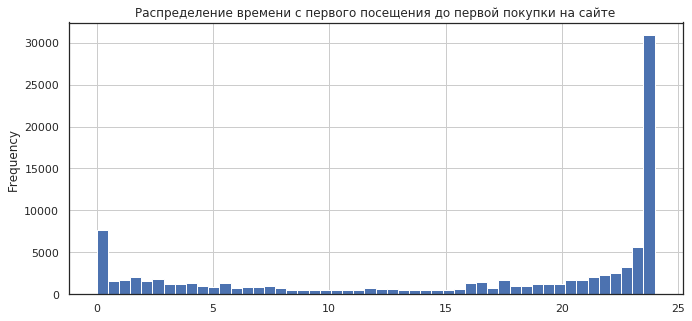

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07-01,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08-01,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN,NaN
2017-09-01,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN,NaN,NaN
2017-10-01,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN,NaN,NaN,NaN
2017-11-01,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5052.0,270.0,202.0,179.0,86.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3783.0,224.0,159.0,64.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4095.0,222.0,83.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
visits['delta'] = (
    (visits[~visits['first_order_datetime'].isna()]['first_activity_datetime'] 
    - visits[~visits['first_order_datetime'].isna()]['first_order_datetime']
    ).dt.seconds
) / 3600 
visits['delta'].plot(
    kind='hist',
    bins=50,
    figsize=(11, 5), 
    grid=True)
plt.title('Распределение времени с первого посещения до первой покупки на сайте')
plt.show()


orders['cohort_lifetime'] = (orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

table = orders.pivot_table(
        index='first_order_month', columns='cohort_lifetime', values='revenue', aggfunc='count'
    )
table

### Вывод
- В среднем с момента первого посещения сайта до покупки проходит 15.8 часов
- Среднее количество покупок на одного пользователя за 6 мес - 1.23 штуки

In [8]:
# Найдем число покупателей в каждой когорте
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

# Добавим в информацию о покупках месяц первой покупки
cohorts = orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'count'}).reset_index()

# Считаем возраст каждой когорты
cohorts['age_month'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1,'M')).round()
cohorts['age_month'] = cohorts['age_month'].astype(int)
cohorts.columns = ['first_order_month', 'order_month', 'n_orders', 'age_month']

# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем количество заказов на каждого покупателя.
cohorts_report = pd.merge(cohort_sizes, cohorts, on = 'first_order_month')
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

# Возростной когортный отчет, показывающий накопительное число покупок на покупателя

cohorts_age = cohorts_report.pivot_table(
    index='first_order_month', 
    columns='age_month', 
    values='orders_per_buyer', 
    aggfunc='sum'
).cumsum(axis=1)

cohorts_age.round(2).fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


### Метрики электронной коммерции

- Рассчет среднего чека, применяя группировку по времени совершения покупки.

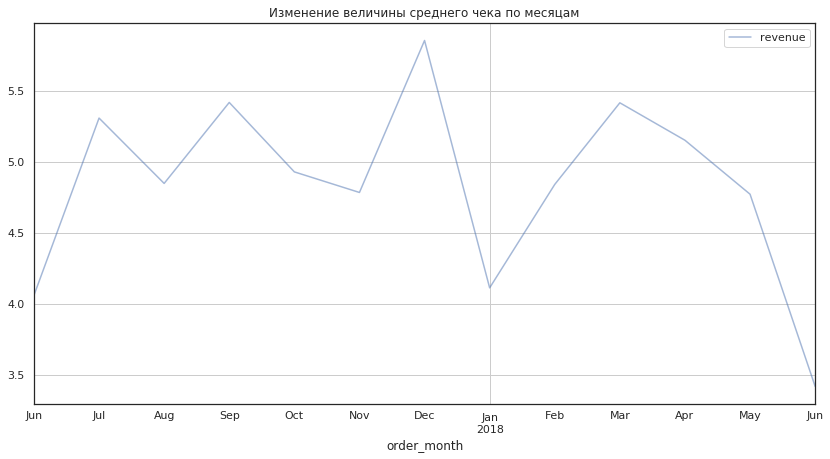

Средний чек по годам:              revenue
buy_ts              
2017-01-01  5.120599
2018-01-01  4.854877


In [9]:
orders['order_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['order_ month'] = orders['buy_ts'].astype('datetime64[M]')
orders.groupby('order_month').agg({'revenue': 'mean'}).plot(
        alpha = 0.5, 
        figsize=(14, 7), 
        grid=True)
plt.legend()
plt.title('Изменение величины среднего чека по месяцам')
plt.show()
av_annual_revenue = orders.groupby(orders['buy_ts'].astype('datetime64[Y]')).agg({'revenue': 'mean'})
print('Средний чек по годам: {}'. format(av_annual_revenue))

### Выводы
- средний чек в 2017 году равен 5.120599 у.е., в 2018 году равен 4.854877 у.е.
- уменьшение среднего чека в 2018 году может быть связано с тем, что за 2018 год данные только до июня, а самые дорогие покупки приходятся на декабрь, за которым идет сильный спад в январе - недостаток средств у покупателей после НГ.

### Метрики электронной коммерции

- Оценка изменения LTV по когортам. Расчет среднего за 6 месяцев. (учитываем маржинальность сервиса - 100%)

In [10]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

cohorts_orders = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

cohorts_orders2 = pd.merge(cohort_sizes, cohorts_orders, on = 'first_order_month')
cohorts_orders2['age'] = ((
    cohorts_orders2['order_month'] - cohorts_orders2['first_order_month']
)/np.timedelta64(1, 'M')
).round().astype('int')
cohorts_orders2['ltv'] = cohorts_orders2['revenue'] / cohorts_orders2['n_buyers']
ltv_res = cohorts_orders2.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).cumsum(axis=1).round(2)

ltv_res.fillna('-')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,-
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,-,-
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,-,-,-
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,-,-,-,-
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,-,-,-,-,-
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,-,-,-,-,-,-
2018-01-01,4.14,4.43,4.73,4.88,4.94,-,-,-,-,-,-,-
2018-02-01,4.16,4.44,4.51,4.59,-,-,-,-,-,-,-,-


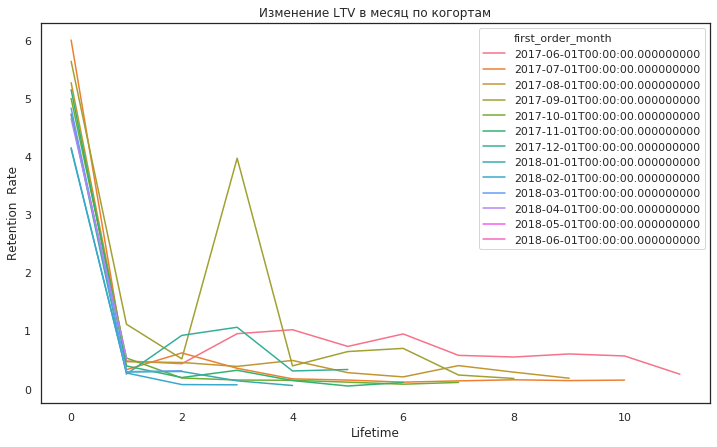

Cреднее LTV для когорт старше 6 месяцев за первые 6 месяцев:


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40


In [11]:
plt.figure(figsize=(12, 7))
sns.lineplot(x='age', y='ltv', hue='first_order_month', data=cohorts_orders2)
plt.ylabel('Retention  Rate')
plt.xlabel('Lifetime')
plt.title('Изменение LTV в месяц по когортам')
plt.show()


#среднее LTV для когорт старше 6 месяцев за первые 6 месяцев
print('Cреднее LTV для когорт старше 6 месяцев за первые 6 месяцев:')
ltv_res_6mnth = cohorts_orders2[cohorts_orders2['first_order_month'] < '2017-12-01'].query(
    'age <= 6'
).pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)
ltv_res_6mnth.cumsum(axis=1).round(2)

### Вывод
- начиная со всплеска в 4-6 единиц, LTV увеличивается каждый следующий месяц жизни когорты на  0-1
- первая когорта самая преданная, LTV растет непрерывно и равномерно 
- у четвертой когорты заметен всплекс на 4ый месяц жизни (age=3)

### Маркетинговые метрики

- Отразить различие маркетинговых метрик по рекламным источникам
- Расчет общих расходов на маркетинг, распределение трат по источникам, визуализация по времени

Общие расходы на маркетинг составляют 329131.62 у.е.


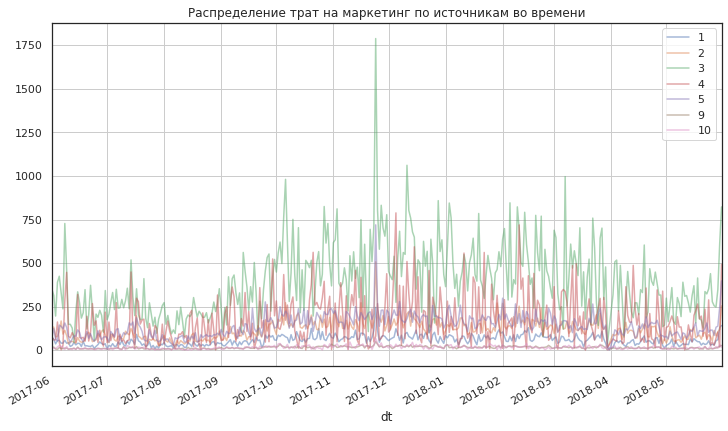

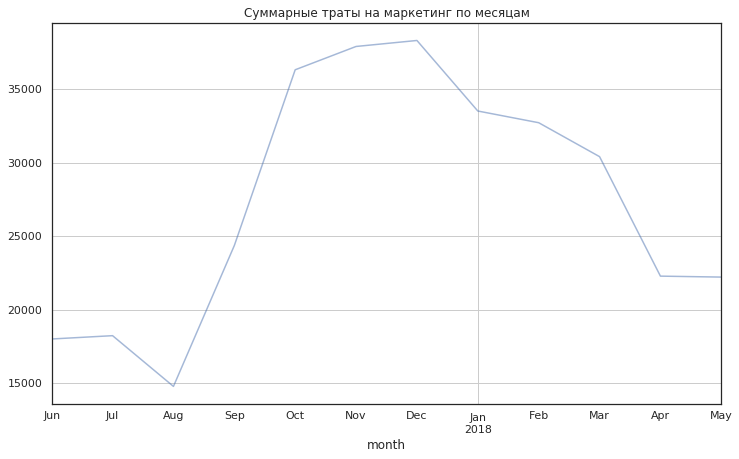

Распределение трат по источникам:


,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


In [12]:
print('Общие расходы на маркетинг составляют {} у.е.'.format(costs['costs'].sum()))
for item in costs['source_id'].unique():
    costs.loc[costs['source_id'] == item].groupby('dt')['costs'].sum().plot(
        label=item, 
        alpha = 0.5, 
        figsize=(12, 7), 
        grid=True)

plt.legend()
plt.title('Распределение трат на маркетинг по источникам во времени')
plt.show()

costs['month'] = costs['dt'].astype('datetime64[M]')
costs.groupby('month')['costs'].sum().plot(
        label=item, 
        alpha = 0.5, 
        figsize=(12, 7), 
        grid=True)
plt.title('Cуммарные траты на маркетинг по месяцам')
plt.show()

print('Распределение трат по источникам:')
costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().sort_values(
    by='costs', ascending=False
)

### Выводы
- Общие расходы на маркетинг по всем источникам составляют 329131.62 у.е
- Больше всего денег потрачено на 3 источник - 141к, 4ый,5ый,2ой - от 42к до 61к, 20к на 1ый, 5,5к-5,8к на 9ый и 10ый источники.

### Маркетинговые метрики
- Рассчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика

In [13]:
cac_all_sources = costs['costs'].sum() / visits[~visits['first_order_datetime'].isna()]['uid'].agg('nunique')
print('Cредний CAC на одного покупателя для всего проекта {:.4f}'.format(cac_all_sources))

def cac(source):
    n_buyers_source = visits[~visits['first_order_datetime'].isna()].query(
        'source_id == @source'
    )['uid'].agg('nunique')
    costs_source = costs.query(
        'source_id == @source'
    ).agg({'costs': 'sum'})
    print('CAC для источника {} равен: {:.4f}'.format(source, float(costs_source/n_buyers_source)))
    
for source in costs['source_id'].unique():
    cac(source)

Cредний CAC на одного покупателя для всего проекта 9.0116
CAC для источника 1 равен: 2.9186
CAC для источника 2 равен: 5.8598
CAC для источника 3 равен: 10.2067
CAC для источника 4 равен: 4.2850
CAC для источника 5 равен: 5.0962
CAC для источника 9 равен: 1.9755
CAC для источника 10 равен: 3.2840


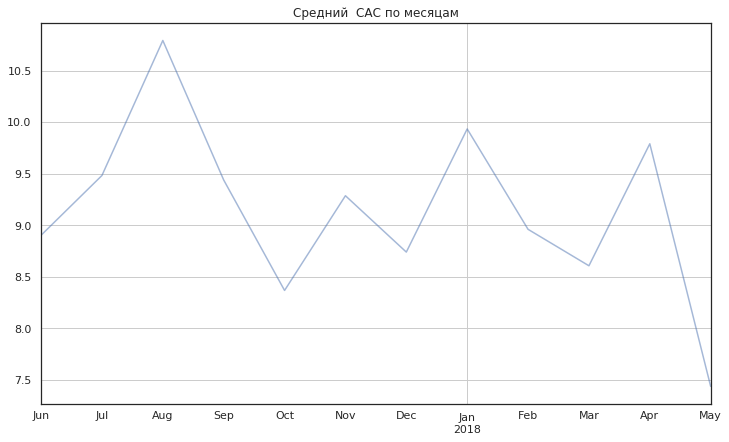

In [14]:
costs_grpd = costs.groupby('month').agg({'costs': 'sum'})
first_order_grpd = first_orders.groupby('first_order_month').agg({'uid': 'nunique'})

costs_grpd = costs_grpd.merge(first_order_grpd, left_index=True, right_index=True)
costs_grpd['cac'] = costs_grpd['costs'] / costs_grpd['uid']
costs_grpd['cac'].plot(
        label=item, 
        alpha = 0.5, 
        figsize=(12, 7), 
        grid=True)
plt.title('Средний  CAC по месяцам')
plt.show()

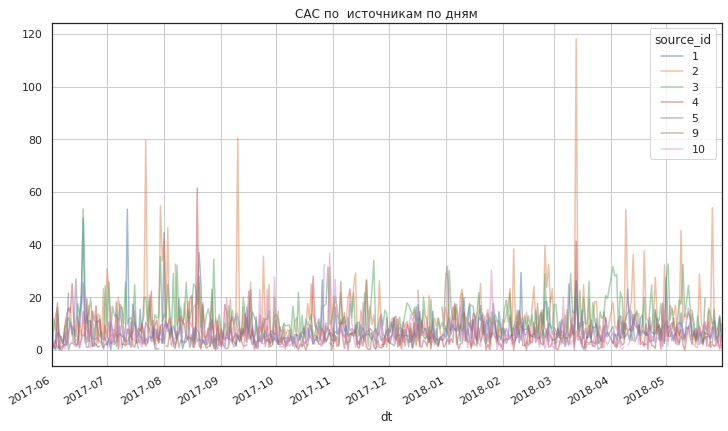

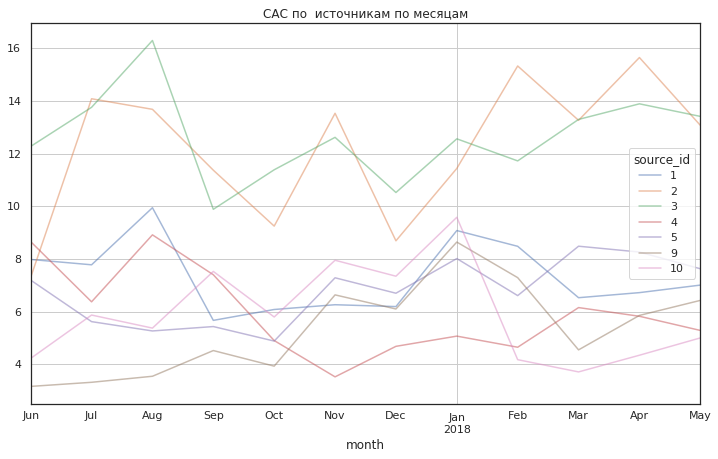

Средний СAC по источникам за все время:


source_id
1      7.302470
2     12.185484
3     12.646742
4      5.957665
5      6.771086
9      5.369890
10     5.943363
Name: cac, dtype: float64

In [15]:
first_source = visits.sort_values('start_ts').groupby('uid').first()
first_source = first_source[['source_id']]
orders['first_order_date'] = orders['first_order_datetime'].astype('datetime64[D]')
orders = orders.merge(first_source, on='uid')

cac_date = orders.groupby(['source_id', 'first_order_date']).agg({'uid': 'count'})
cac_date = cac_date.merge(
    costs, left_on=['source_id', 'first_order_date'], right_on = ['source_id', 'dt'])
cac_date['cac'] = cac_date['costs'] / cac_date['uid']

cac_date.pivot_table(index = 'dt', columns = 'source_id', values = 'cac').plot(
        alpha = 0.5, 
        figsize=(12, 7), 
        grid=True)
plt.title('CAC по  источникам по дням')
plt.show()

cac_date['month'] = cac_date['dt'].astype('datetime64[M]')
cac_date.pivot_table(index = 'month', columns = 'source_id', values = 'cac').plot(
        alpha = 0.5, 
        figsize=(12, 7), 
        grid=True)
plt.title('CAC по  источникам по месяцам')
plt.show()

print('Средний СAC по источникам за все время:')
cac_date.groupby('source_id')['cac'].mean()

### Маркетинговые метрики


- Рассчет ROMI по когортам в разрезе источников.
- Сравнение окупаемости за одинаковые периоды жизни когорт.

In [16]:
#все начинаю с начала
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')


visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()


visits = visits.rename(
    {'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts'}, 
    axis='columns'
)
orders = orders.rename(
    {'buy ts': 'buy_ts'},
    axis='columns'
)
visits = visits.astype(
    {'end_ts': 'datetime64', 'start_ts': 'datetime64'}
)
orders = orders.astype(
    {'buy_ts': 'datetime64'}
)
costs = costs.astype(
    {'dt': 'datetime64'}
)


#группировка по uid и месяц первого заказа для каждого
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']


#группировка по uid и первый источник для каждого
first_source = visits.sort_values('start_ts').groupby('uid').first()
first_source = first_source[['source_id']]

#группировка по uid и месяцу заказ и просуммированный доход
month_orders = (
        orders.groupby(['uid', 'order_month'])
        .agg({'revenue': 'sum'})
        .reset_index()
    )

In [17]:
#объединяем
table_join = pd.merge(first_orders, first_source, on='uid')

#объединяем c cohorts_orders, заказы нам важнее - их больше, 
#к ним добавляем месяц первого заказа и источник первого входа
table_join = pd.merge(month_orders, table_join, on='uid', how='left').reset_index()

In [18]:
#группируем по источнику и первому месяцу заказа, только уникальные пользователи
cohorts_size = table_join.groupby(
    ['source_id', 'first_order_month']
).agg({'uid': 'nunique'}).reset_index()
cohorts_size.columns = ['source_id', 'first_order_month', 'n_buyers']

#группируем по источнику и первому месяцу заказа, суммируем доход
#добавил в группировку месяц заказа для расчета age

cohorts_orders = table_join.groupby(
    ['source_id', 
     'order_month', 
     'first_order_month']
).agg({'revenue': 'sum'}).reset_index()

#объединяем полученные таблицы по источнику и первому месяцу покупки
cohorts_orders = pd.merge(
    cohorts_size, 
    cohorts_orders, 
    on = ['source_id', 'first_order_month']
)

In [19]:
#считаем age и ltv
cohorts_orders['age'] = (
    (cohorts_orders['order_month'] - cohorts_orders['first_order_month']) / np.timedelta64(1, 'M')
).round().astype('int')
cohorts_orders['ltv'] = cohorts_orders['revenue'] / cohorts_orders['n_buyers']

costs['month'] = costs['dt'].astype('datetime64[M]')

cohorts_orders = cohorts_orders.merge(
    costs.groupby(['source_id', 'month']
                 ).agg({'costs': 'sum'}).reset_index(), 
    left_on=['source_id', 'first_order_month'], right_on=['source_id', 'month']
)

cohorts_orders['cac'] = cohorts_orders['costs']/cohorts_orders['n_buyers']
cohorts_orders['romi'] = cohorts_orders['ltv']/cohorts_orders['cac']

cohorts_orders

,source_id,first_order_month,n_buyers,order_month,revenue,age,ltv,month,costs,cac,romi
0,1,2017-06-01,190,2017-06-01,1378.70,0,7.256316,2017-06-01,1125.61,5.924263,1.224847
1,1,2017-06-01,190,2017-07-01,414.98,1,2.184105,2017-06-01,1125.61,5.924263,0.368671
2,1,2017-06-01,190,2017-08-01,419.43,2,2.207526,2017-06-01,1125.61,5.924263,0.372625
3,1,2017-06-01,190,2017-09-01,714.24,3,3.759158,2017-06-01,1125.61,5.924263,0.634536
4,1,2017-06-01,190,2017-10-01,811.20,4,4.269474,2017-06-01,1125.61,5.924263,0.720676
...,...,...,...,...,...,...,...,...,...,...,...
509,10,2018-03-01,186,2018-03-01,638.44,0,3.432473,2018-03-01,526.41,2.830161,1.212819
510,10,2018-03-01,186,2018-04-01,12.71,1,0.068333,2018-03-01,526.41,2.830161,0.024145
511,10,2018-03-01,186,2018-05-01,6.29,2,0.033817,2018-03-01,526.41,2.830161,0.011949
512,10,2018-04-01,107,2018-04-01,261.93,0,2.447944,2018-04-01,388.25,3.628505,0.674643


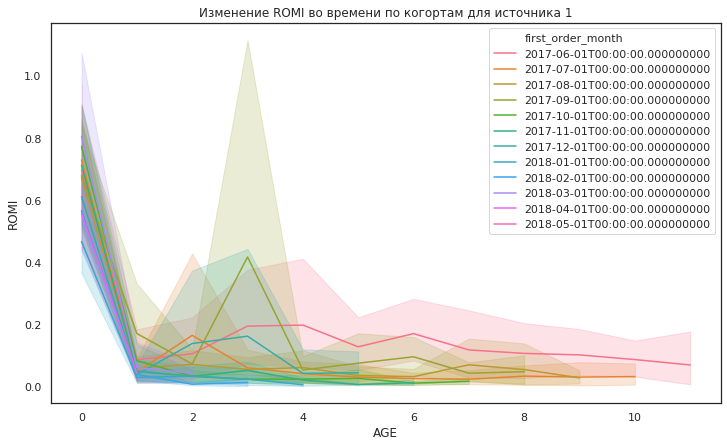

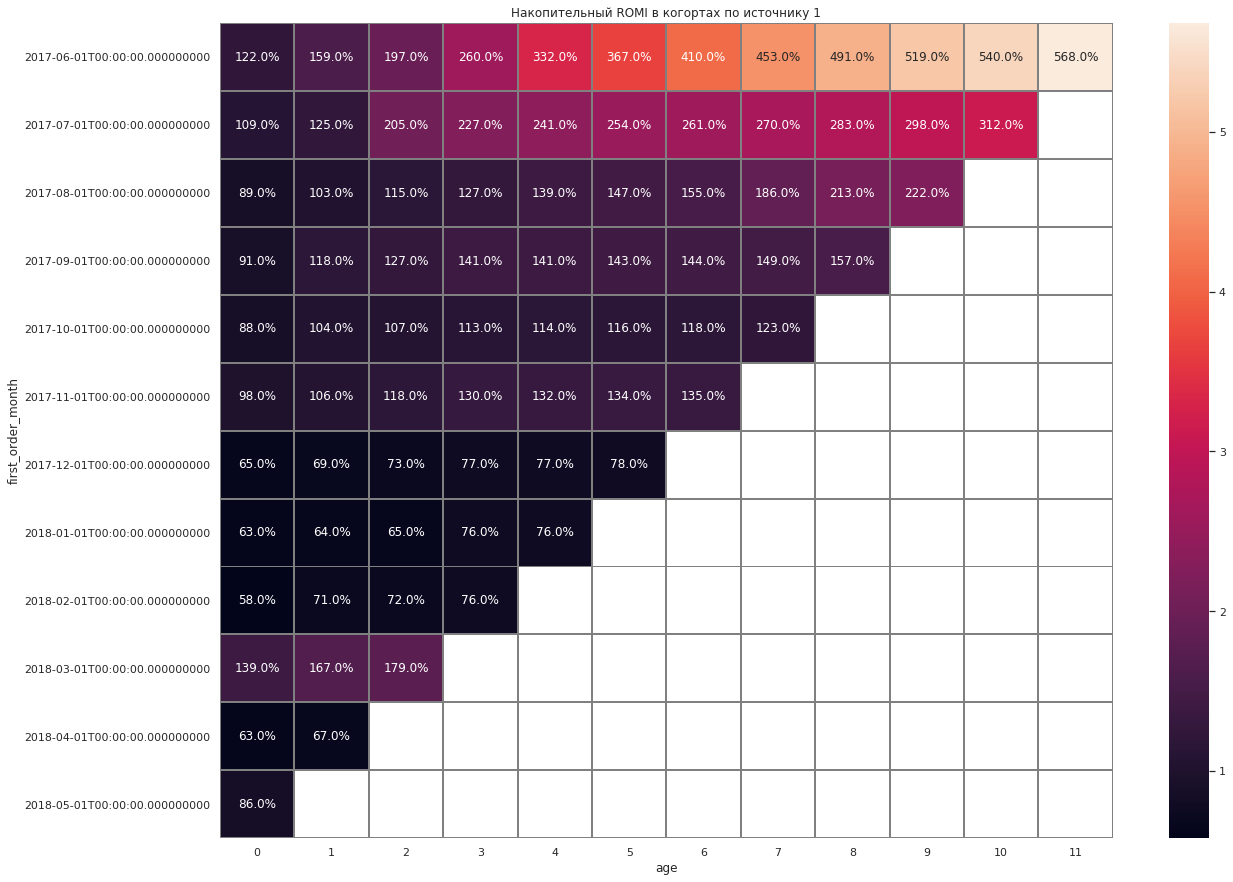

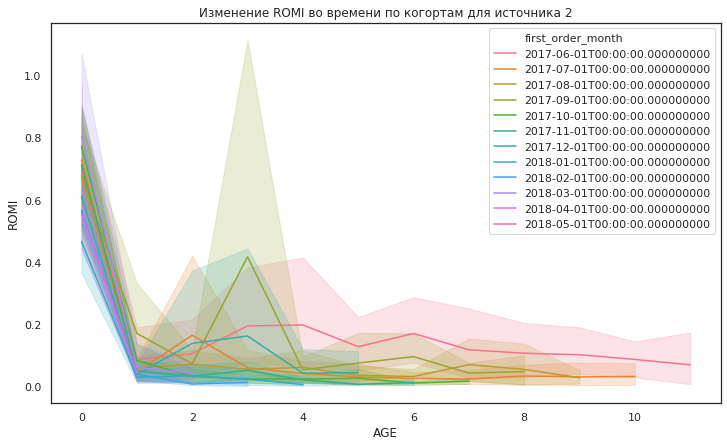

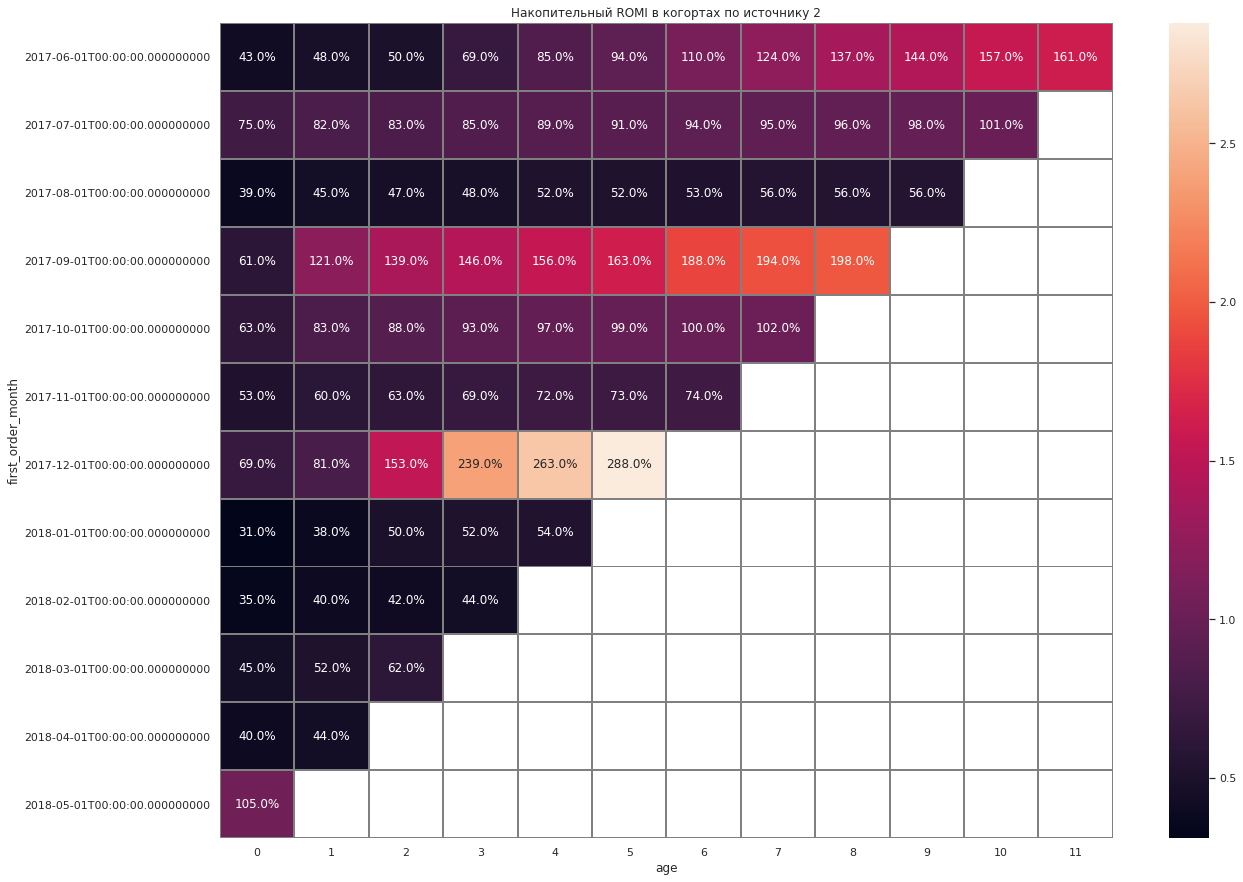

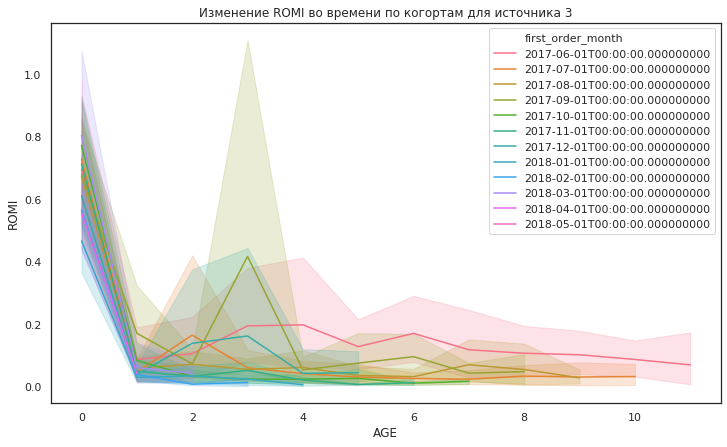

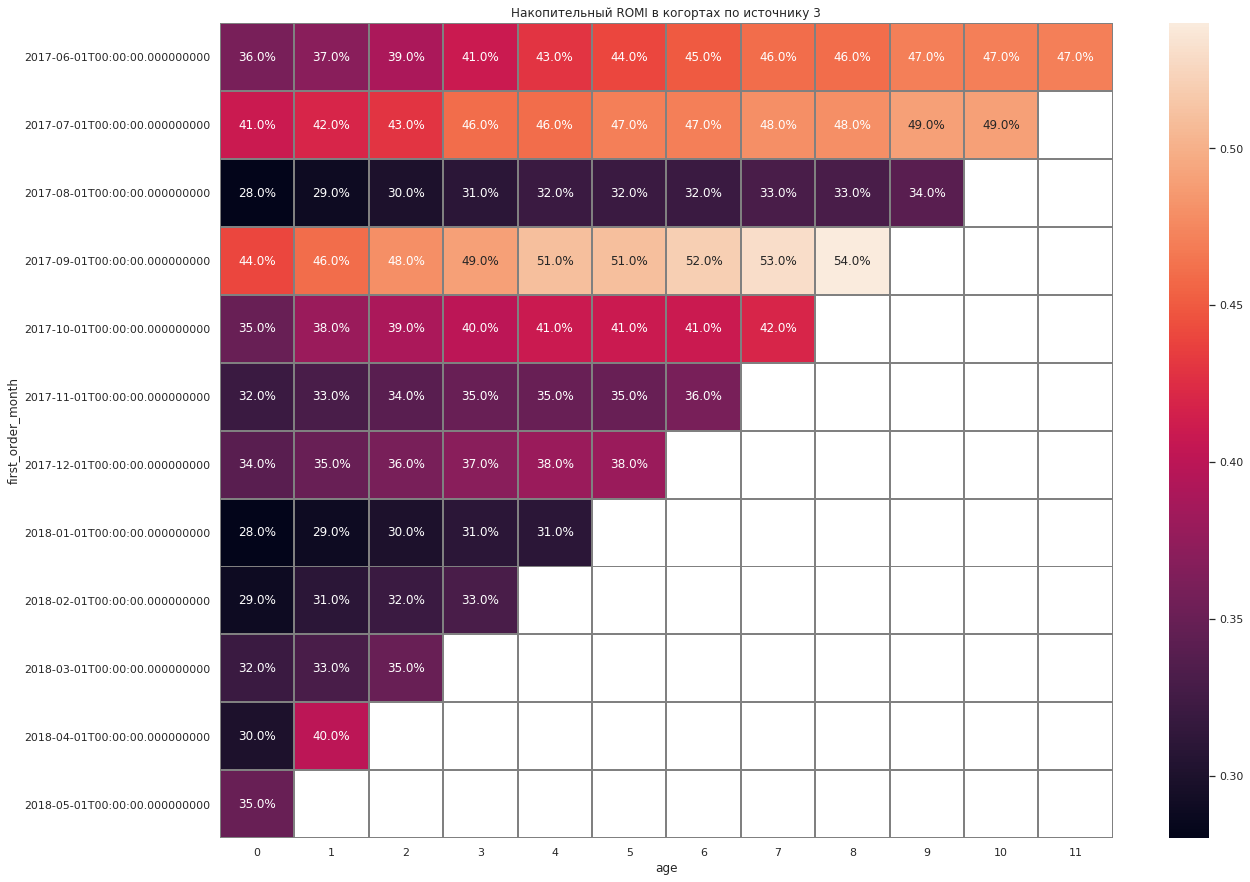

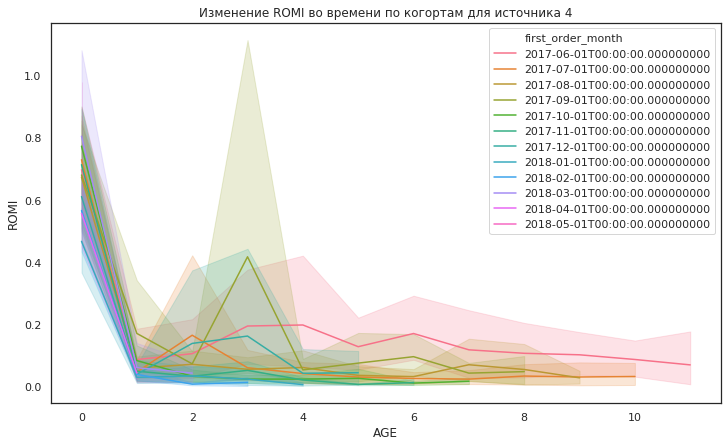

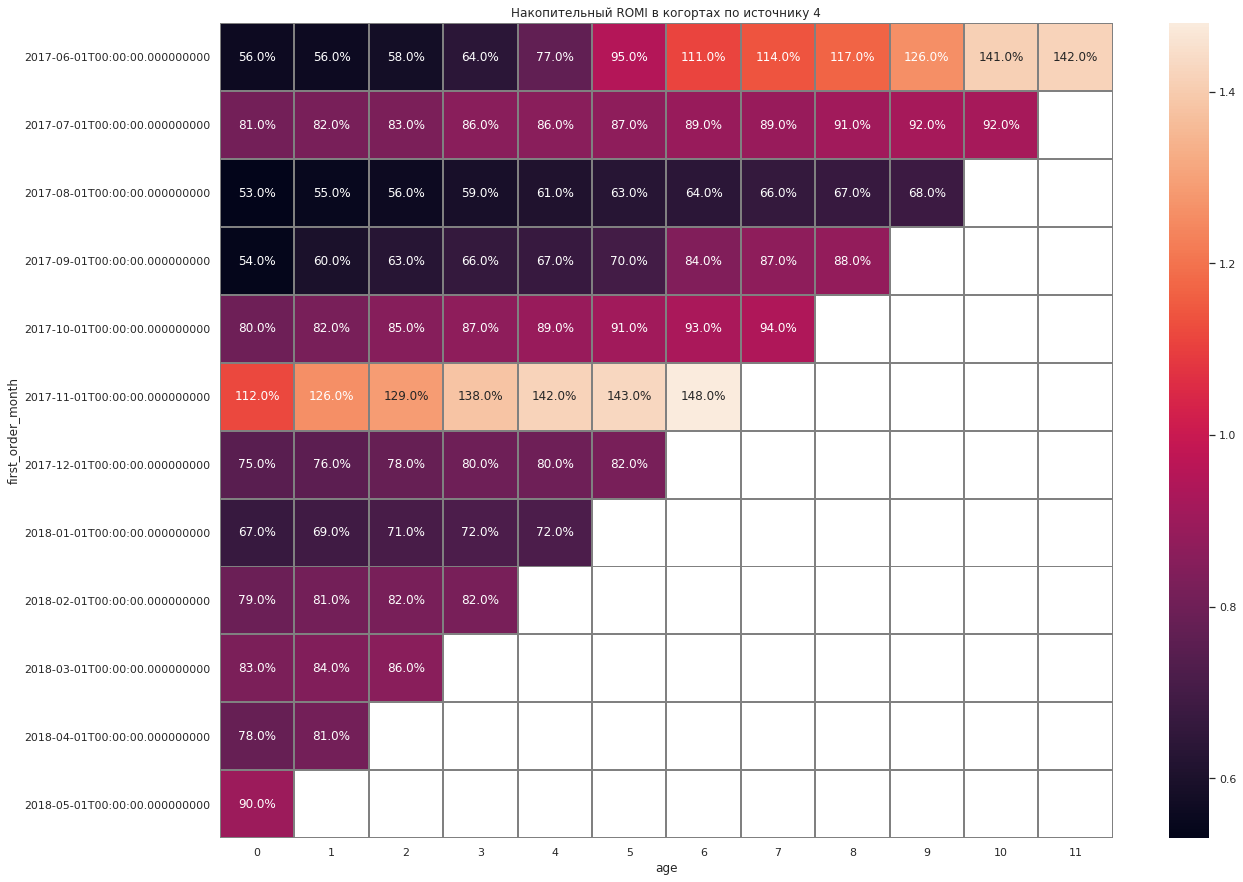

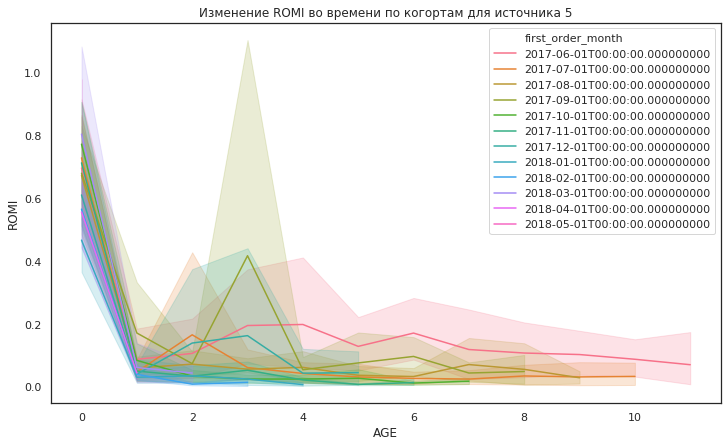

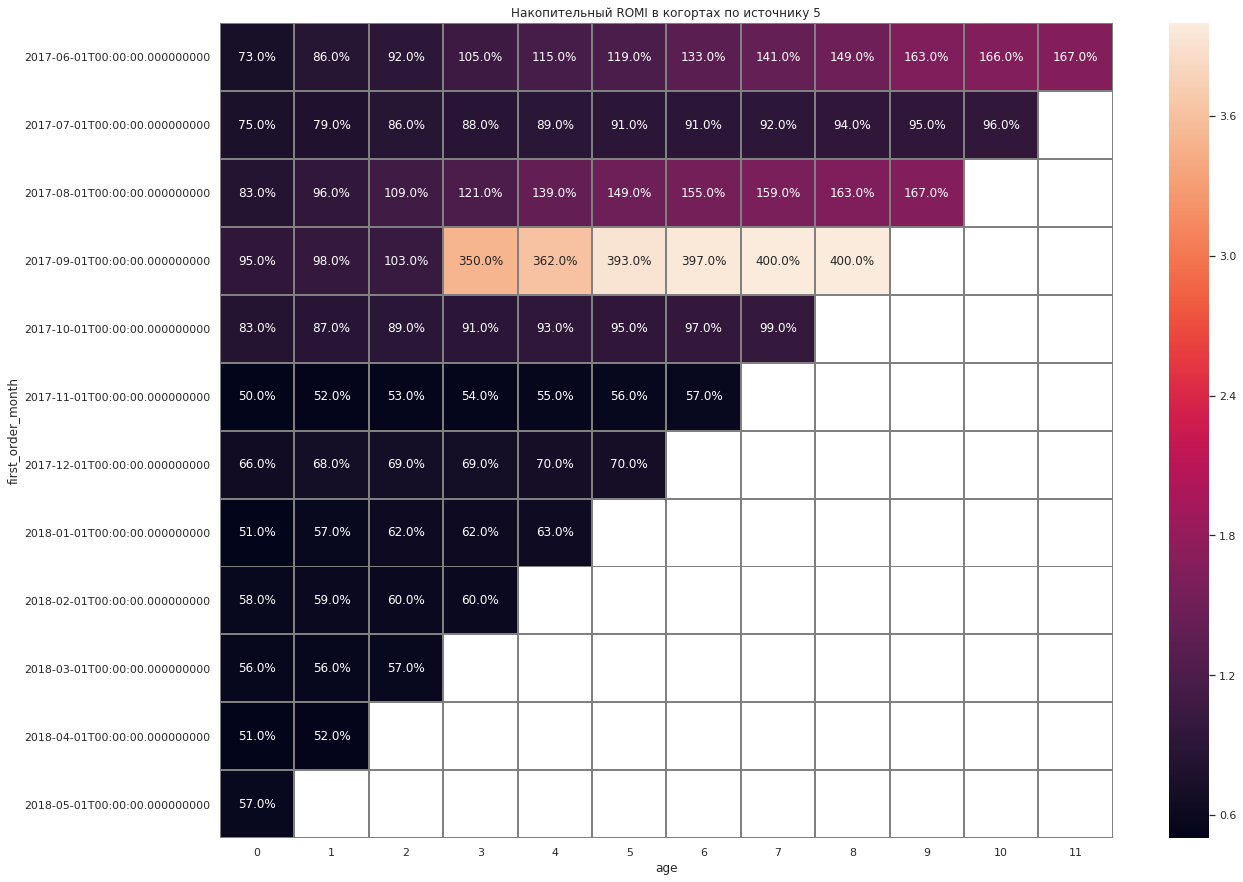

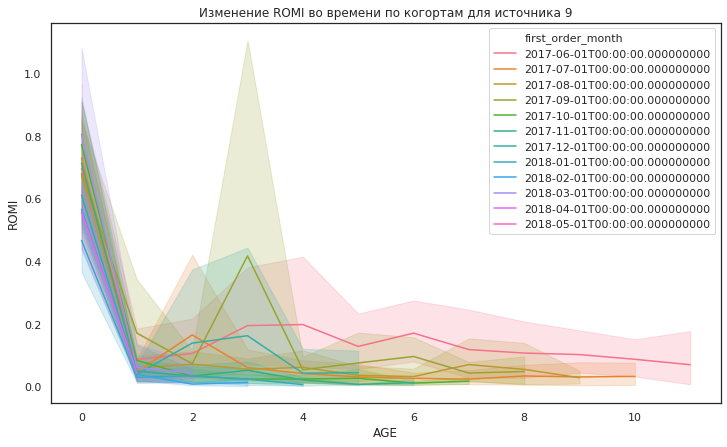

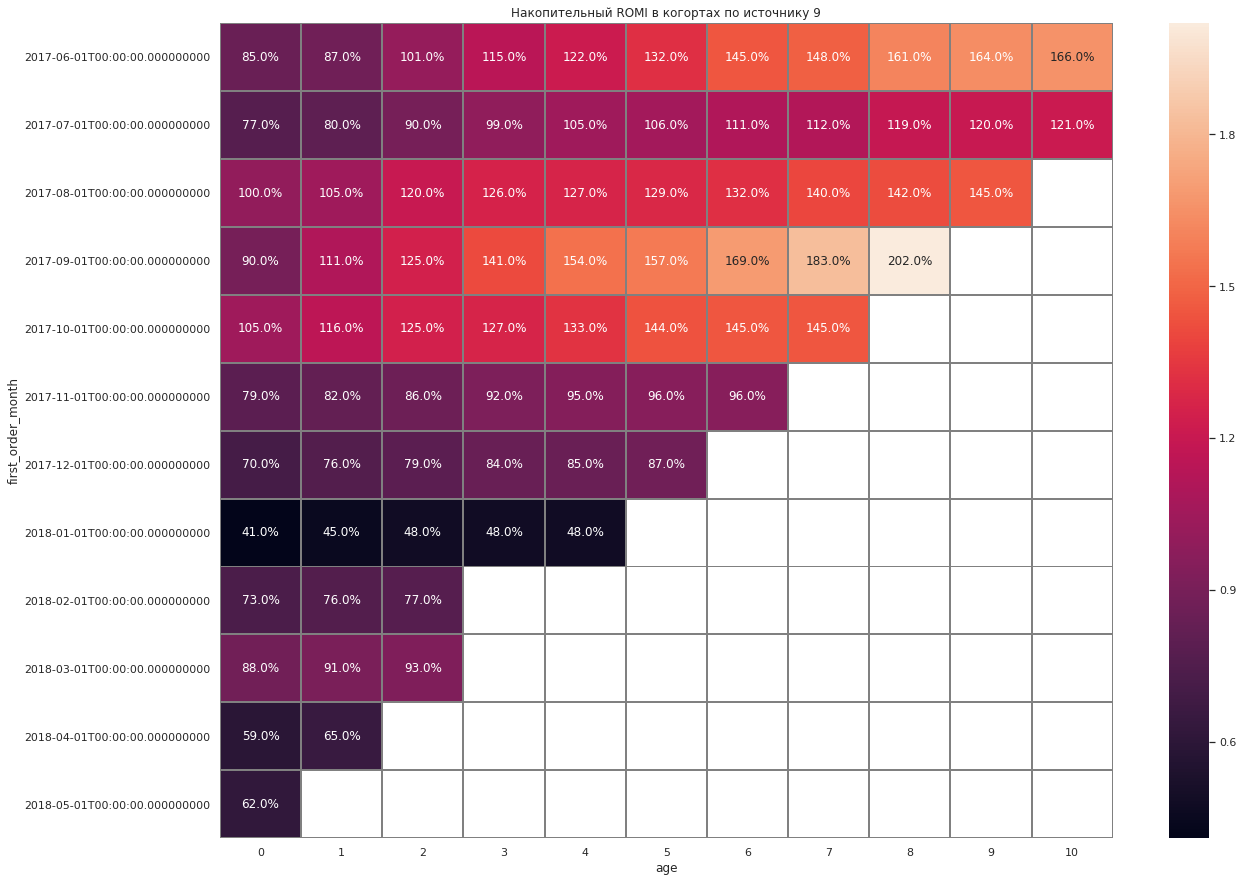

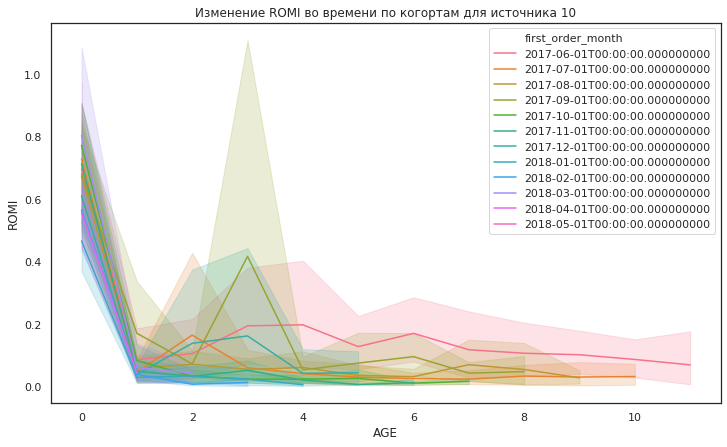

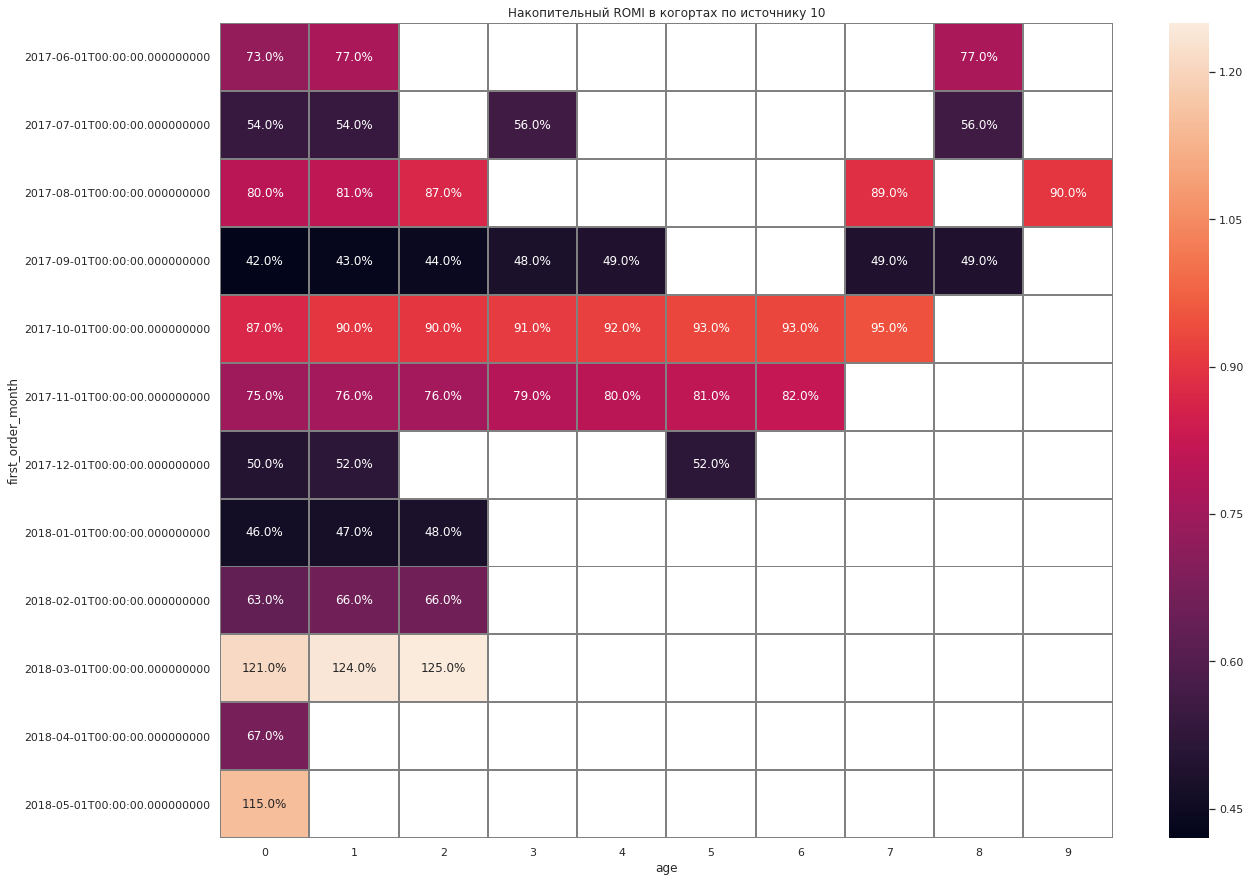

In [20]:
for source in cohorts_orders['source_id'].unique():
    output = cohorts_orders[cohorts_orders['source_id'] == source].pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
    )
    plt.figure(figsize=(12, 7))
    sns.lineplot(x='age', y='romi', hue='first_order_month', data=cohorts_orders)
    plt.ylabel('ROMI')
    plt.xlabel('AGE')
    plt.title('Изменение ROMI во времени по когортам для источника {}'.format(source))
    plt.show()
    
    sns.set(style='white')
    plt.figure(figsize=(20, 15))
    plt.title('Накопительный ROMI в когортах по источнику {}'.format(source))
    sns.heatmap(output.cumsum(axis=1).round(2), annot=True, fmt='.1%', linewidths=1, linecolor='gray')

## Выводы:

**Продуктовые метрики**
- средние DAU - 907, WAU - 5716, MAU - 23228
- распределение посещений сайта в день очень походе график на DAU, среднее значение посещений 987 против 907 уникальных посещений. 
*Это говорит о том, что 90% посещений сайта уникальные, мало кто посещяет сайт более 1 раза в день.*
- Обычно сессия длится 60 секунд. 

**Метрики электронной коммерции**
- посчитал Retantion Rate по когортам, в среднем, по всем когортам он падает, но у первой когорты он держится выше 4% все 11 месяцев
- у более молодых когорт падение происходит быстрее, видимо, спал ажиотаж на покупку билетов на Яндекс.Афише. 
- в среднем, Retantion Rate на второй месяц составляет 6.5%
- когорты от 2017-12-01 пробивают 4% вниз по Retention Rate уже со второго месяца существования когорты.

*Маркетологам стоит заняться удержанием клиентов, предлагать больше скидок и программ лояльности для пользователей со второго-третьего месяца.*

- в среднем с момента первого посещения сайта до покупки проходит 15.8 часов
- среднее количество покупок на одного пользователя за 6 мес - 1.23 покупки
- средний чек в 2017 году равен 5.120599 у.е., в 2018 году равен 4.854877 у.е.

*Уменьшение среднего чека в 2018 году может быть связано с тем, что за 2018 год данные неполные - только до июня, а самые дорогие покупки приходятся на декабрь, за которым идет сильный спад в январе.*

- начиная со всплеска в 4-6 единиц, LTV увеличивается каждый следующий месяц жизни когорты на  0-1
- первая когорта самая преданная, LTV растет непрерывно и равномерно 
- у четвертой когорты заметен всплекс на 4ый месяц жизни (age=3)

**Маркетинговые метрики**
- Общие расходы на маркетинг по всем источникам составляют 329131.62 у.е
- Больше всего денег потрачено на 3 источник - 141к - почти половина всего бюджета!, 4ый, 5ый, 2ой - от 42к до 61к, 1ый - 20к на , 9ый и 10ый источники - 5,5к-5,8к.
- Cредний CAC на одного покупателя для всего проекта 9.0116
- CAC для источника 1 равен: 2.9186
- CAC для источника 2 равен: 5.8598
- CAC для источника 3 равен: 10.2067
- CAC для источника 4 равен: 4.2850
- CAC для источника 5 равен: 5.0962
- CAC для источника 9 равен: 1.9755
- CAC для источника 10 равен: 3.2840

*Ошибкой маркетологов было лить такой большой трафик в один источник, оказавшийся по итогу самым дорогим. Правильнее увеличивать бюджеты самых дешевых источников, наблюдая за CAC, регулируя бюджет.*